In [68]:
import os

from models.vae import DenseVariationalAutoencoder
from models.utils.loaders import load_mnist
import pandas as pd
import numpy as np
from tensorflow.python.framework.ops import disable_eager_execution
from matplotlib import pyplot as plt

disable_eager_execution()

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

N_DENSE = 1
L=8
TRAINING_FRACTION = 0.8
NON_LINEAR_ACTIVATION_BOOL=True

In [69]:
user = 1
if user == 1:
    prefix_s3 = "/home/owen/"
    prefix_data = "/home/owen/repos/"
elif user == 2:
    prefix_data = "/Users/omyers/repos/"

In [70]:
# run params
SECTION = 'vae'
RUN_ID = '0003'
#DATA_NAME = 'digits'
DATA_NAME = 'ising'
RUN_FOLDER = '{}/run/{}/'.format(os.getcwd(), SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #


In [71]:
df_bins = pd.read_csv("{prefix_data}z3support/data/SpinMLData/2DIsing/L-{L}/L-{L}-T-1-5/bins_L-{L}-T-1-5.txt".format(L=L,prefix_data=prefix_data), sep="\t")
df_conf = pd.read_csv("{prefix_data}z3support/data/SpinMLData/2DIsing/L-{L}/L-{L}-T-1-5/spinConfigs_L-{L}-T-1-5.txt".format(L=L,prefix_data=prefix_data), delimiter=r"\s+", header=None)

In [72]:
df_bins = df_bins[df_bins[' T '] != ' T ']

In [73]:
df_bins = df_bins.astype(
    {
        " T ": int,
        " binNum": int,
    }
)

## Get the temp and magnatization into the configuration dataframe

In [74]:
df_conf["T"] = df_bins[" T "]

In [75]:
mean_col = df_conf[0].copy()
for i in range(1, L):
    mean_col += df_conf[i]

mean_col /= L

In [76]:
df_conf["M"] = mean_col

In [77]:
#filterned_confs = df_conf
filterned_confs = df_conf[(df_conf["T"] < 1.5) | (df_conf["T"] > 4.5)]

In [78]:
filterned_confs.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,T,M
0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.0,-1.0
1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.0,-1.0
2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.0,-1.0
3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.0,-1.0
4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.0,-1.0


We need the data in the format: `(x_train, y_train), (x_test, y_test)`

In [79]:
train_with_meta_info = filterned_confs.sample(frac=TRAINING_FRACTION, axis=0)
test_with_meta_info = filterned_confs.drop(index=train_with_meta_info.index)

In [80]:
train = train_with_meta_info.drop(["T","M"], axis=1)
test = test_with_meta_info.drop(["T","M"], axis=1)

# Check what MNIST data looked like

In [81]:
(x_train, y_train), (x_test, y_test) = load_mnist()

In [82]:
np.shape(x_train)

(60000, 28, 28, 1)

In [83]:
np.shape(x_train)

(60000, 28, 28, 1)

## Make our data the same

In [84]:
train.to_numpy().shape

(4000, 64)

In [85]:
x = train.to_numpy().reshape(-1,L*L)
x_test = test.to_numpy().reshape(-1,L*L)

In [86]:
np.array([[1,1,1,1], [2,2,3,3], [4,4,5,5]]).reshape(-1,2)

array([[1, 1],
       [1, 1],
       [2, 2],
       [3, 3],
       [4, 4],
       [5, 5]])

In [87]:
x = x.astype(float)

In [88]:
x.shape

(4000, 64)

## Run Convolutional VAE

In [89]:
vae = DenseVariationalAutoencoder(
    input_dim=(L*L,),
    encoder_layer_sizes=[2],
    decoder_layer_sizes=[2, L*L],
    z_dim=2,
    non_linear_activation_bool=NON_LINEAR_ACTIVATION_BOOL
)

In [90]:
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 1000

In [91]:
vae.compile(LEARNING_RATE, R_LOSS_FACTOR)

In [99]:
BATCH_SIZE = 16
EPOCHS = 50
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

In [100]:
vae.train(     
    x,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    run_folder = RUN_FOLDER,
    print_every_n_batches = PRINT_EVERY_N_BATCHES,
    initial_epoch = INITIAL_EPOCH,
)

Train on 4000 samples
Epoch 1/50
4000/4000 [==============================] - 0s 41us/sample - loss: 810.7530 - vae_r_loss: 802.1075 - vae_kl_loss: 8.6455
Epoch 2/50
4000/4000 [==============================] - 0s 34us/sample - loss: 809.5769 - vae_r_loss: 801.4417 - vae_kl_loss: 8.1352
Epoch 3/50
4000/4000 [==============================] - 0s 35us/sample - loss: 809.6876 - vae_r_loss: 801.9957 - vae_kl_loss: 7.6915
Epoch 4/50
4000/4000 [==============================] - 0s 35us/sample - loss: 808.6457 - vae_r_loss: 801.1702 - vae_kl_loss: 7.4753
Epoch 5/50
4000/4000 [==============================] - 0s 35us/sample - loss: 808.6688 - vae_r_loss: 801.5764 - vae_kl_loss: 7.0925
Epoch 6/50
4000/4000 [==============================] - 0s 35us/sample - loss: 807.5166 - vae_r_loss: 800.6476 - vae_kl_loss: 6.8689
Epoch 7/50
4000/4000 [==============================] - 0s 35us/sample - loss: 807.3456 - vae_r_loss: 800.7061 - vae_kl_loss: 6.6397
Epoch 8/50
4000/4000 [=========================

/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


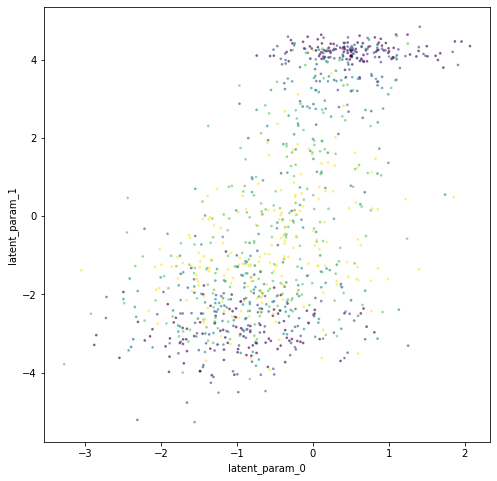

In [27]:
figsize = 8

z_points = vae.encoder.predict(x_test)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
#plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
plt.scatter(z_points[:, 0] , z_points[:, 1], c=test_with_meta_info['T'], alpha=0.5, s=3)
plt.xlabel("latent_param_0")
plt.ylabel("latent_param_1")
plt.show()

In [101]:
test_with_meta_info[test_with_meta_info['T'] < 2]

,index,0,1,2,3,4,5,6,7,8,...,56,57,58,59,60,61,62,63,T,M
0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.0,-1.0
1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.0,-1.0
2,4,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.0,-1.0
3,9,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.0,-1.0
4,10,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,989,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1.0,1.0
206,991,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.0,-1.0
207,995,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.0,-1.0
208,996,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.0,-1.0


In [102]:
test_with_meta_info[test_with_meta_info['T'] < 2].index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            200, 201, 202, 203, 204, 205, 206, 207, 208, 209],
           dtype='int64', length=210)

In [103]:
#len(x_test)
test_with_meta_info = test_with_meta_info.reset_index()

Text(0.5, 0, 'latent_param')

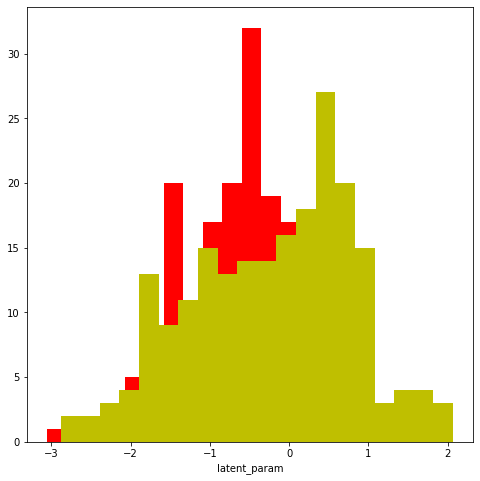

In [104]:
plt.figure(figsize=(figsize, figsize))
plt.hist(z_points[:, 0][test_with_meta_info[test_with_meta_info['T'] > 4].index], color='r', bins=20)
plt.hist(z_points[:, 0][test_with_meta_info[test_with_meta_info['T'] < 2].index], color='y', bins=20)
plt.xlabel("latent_param")

Text(0, 0.5, 'latent parameter')

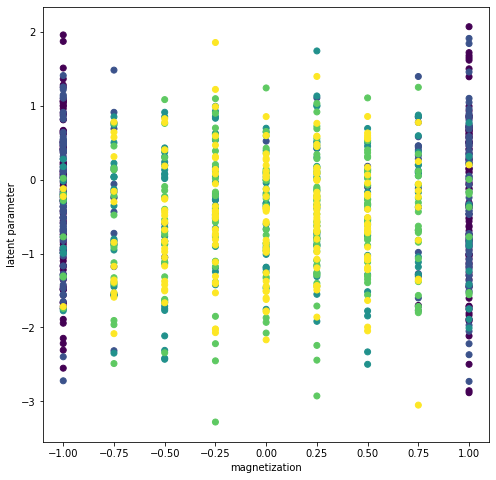

In [105]:
plt.figure(figsize=(figsize, figsize))
plt.scatter(test_with_meta_info['M'], z_points[:,0], c=test_with_meta_info['T'])
plt.xlabel("magnetization")
plt.ylabel("latent parameter")